## **Identifying Fraudulent Transactions:**  

#### **Objective of the Project:**
- The Objective of this project is to build a Predictive model to determine whether a given transaction will be fraudulent or not.
- Identifying fraudulent transaction is crucial for Financial and Banking domains to reduce financial loss and to improve customer satisfaction.


**Business Goal:**
- Maximize fraud detection (recall) without too many false positives (precision trade-off).
- Handle time-based anomalies (multi-swipes or reversals within short intervals).


In This Project we have covered below Analysis:  

Importing the jsonlines library because the data is in text format, specifically structured as JSONLines (where each line is a valid JSON object). The jsonlines library allows me to efficiently read and process this type of data line by line, which is particularly useful for large datasets.

In [14]:
pip install jsonlines


This line loads line delimited JSON data from a txt file where each line is a JSON object which handles invalid lines gracefully, and converts the cleaned data into a structured pandas dataFrame for analysis.


In [16]:
import jsonlines
import pandas as pd
from datetime import datetime
#import sys
#print(sys.executable)

data = []

with jsonlines.open("/content/transactions data.txt") as reader:
  for obj in reader.iter(skip_invalid=True): # Used Skip_invalid as True to ignore any error related to extra characters after valid JSON Object
    data.append(obj)

data = pd.DataFrame(data)



## **Exploring the data set:**

In [17]:
print(data.info())  # Print a summary of the DataFrame (columns, types, etc.)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28425 entries, 0 to 28424
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   accountNumber             28425 non-null  object 
 1   customerId                28425 non-null  object 
 2   creditLimit               28425 non-null  float64
 3   availableMoney            28425 non-null  float64
 4   transactionDateTime       28425 non-null  object 
 5   transactionAmount         28425 non-null  float64
 6   merchantName              28425 non-null  object 
 7   acqCountry                28425 non-null  object 
 8   merchantCountryCode       28425 non-null  object 
 9   posEntryMode              28425 non-null  object 
 10  posConditionCode          28425 non-null  object 
 11  merchantCategoryCode      28425 non-null  object 
 12  currentExpDate            28425 non-null  object 
 13  accountOpenDate           28425 non-null  object 
 14  dateOf

#### **Missing Values**:

The dataset was checked for missing values using the isnull().sum() method, which returns the count of null entries for each column.


In [18]:
# Check remaining missing values
missing_summary = data.isnull().sum()
print(missing_summary)

accountNumber               0
customerId                  0
creditLimit                 0
availableMoney              0
transactionDateTime         0
transactionAmount           0
merchantName                0
acqCountry                  0
merchantCountryCode         0
posEntryMode                0
posConditionCode            0
merchantCategoryCode        0
currentExpDate              0
accountOpenDate             0
dateOfLastAddressChange     0
cardCVV                     0
enteredCVV                  0
cardLast4Digits             0
transactionType             0
echoBuffer                  0
currentBalance              0
merchantCity                0
merchantState               0
merchantZip                 0
cardPresent                 0
posOnPremises               0
recurringAuthInd            0
expirationDateKeyInMatch    0
isFraud                     0
dtype: int64


In [82]:
import numpy as np
from scipy import stats

# ----------------------------
# 1. Detect Outliers using Z-Score
# ----------------------------
def detect_outliers_zscore(data, threshold=3):
    z_scores = np.abs(stats.zscore(data))
    outliers = (z_scores > threshold)
    return outliers

# Apply to numeric columns
z_outliers = data.select_dtypes(include=[np.number]).apply(detect_outliers_zscore)

# Combine results
data["Z_Outlier"] = z_outliers.any(axis=1)


# ----------------------------
# 2. Detect Outliers using IQR
# ----------------------------
def detect_outliers_iqr(data, factor=1.5):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR
    outliers = (data < lower_bound) | (data > upper_bound)
    return outliers

# Apply to numeric columns
iqr_outliers = data.select_dtypes(include=[np.number]).apply(detect_outliers_iqr)

# Combine results
data["IQR_Outlier"] = iqr_outliers.any(axis=1)


# ----------------------------
# Final: Both methods
# ----------------------------
print("Outliers detected using Z-Score:", data["Z_Outlier"].sum())
print("Outliers detected using IQR:", data["IQR_Outlier"].sum())

Outliers detected using Z-Score: 2325
Outliers detected using IQR: 5369


In [105]:
# Count merchant frequencies
counts = data["merchantName"].value_counts()

# Pick threshold (e.g. 500)
threshold = 500
repl = counts[counts <= threshold].index.tolist()

# Replace rare merchants with "Other"
data["merchantName"] = data["merchantName"].replace(repl, "Other")

In [106]:
# Count unique values in each column
unique_counts = data.nunique()

# Display the result
print("Unique value count per column:")
print(unique_counts)

Unique value count per column:
creditLimit                    10
availableMoney              25003
transactionDateTime         28410
transactionAmount           17282
merchantName                   15
acqCountry                      5
merchantCountryCode             5
posEntryMode                    6
merchantCategoryCode           19
currentExpDate                165
accountOpenDate               248
dateOfLastAddressChange       328
transactionType                 4
currentBalance              24662
cardPresent                     2
expirationDateKeyInMatch        2
isFraud                         2
cvv_match                       2
Z_Outlier                       2
IQR_Outlier                     2
dtype: int64


Dropped customerID and AccountNumber from analysis as it does not have much significance and predictive power.


In [107]:

data = data.drop(columns=['customerId','accountNumber'])

KeyError: "['customerId', 'accountNumber'] not found in axis"

Several columns were found to contain empty strings and no associated values like echoBuffer, merchantCity, merchantState, merchantZip, posOnPremises  and recurringAuthInd. Hence, removing these features as they offer no analytical insigts towards our goal, keeping them would increase processing time and requires more memory.


In [25]:
cols_to_drop = [
    'echoBuffer', 'merchantCity', 'merchantState',
    'merchantZip', 'posOnPremises', 'posConditionCode',  'recurringAuthInd'
]
data = data.drop(columns=cols_to_drop)

In [26]:
import numpy as np

empty_counts_sum = data.replace(r'^\s*$', np.nan, regex=True).isna().sum()
print(empty_counts_sum[empty_counts_sum > 0])


acqCountry             168
merchantCountryCode     27
posEntryMode           175
transactionType         25
dtype: int64


In [27]:
total_rows = len(data)
missing_pct = (empty_counts_sum / total_rows) * 100
print(missing_pct)


creditLimit                 0.000000
availableMoney              0.000000
transactionDateTime         0.000000
transactionAmount           0.000000
merchantName                0.000000
acqCountry                  0.591029
merchantCountryCode         0.094987
posEntryMode                0.615655
merchantCategoryCode        0.000000
currentExpDate              0.000000
accountOpenDate             0.000000
dateOfLastAddressChange     0.000000
cardCVV                     0.000000
enteredCVV                  0.000000
cardLast4Digits             0.000000
transactionType             0.087951
currentBalance              0.000000
cardPresent                 0.000000
expirationDateKeyInMatch    0.000000
isFraud                     0.000000
dtype: float64


In [28]:
import pandas as pd

# Example: df is your DataFrame
date_cols = ["dateOfLastAddressChange", "accountOpenDate", "currentExpDate", "transactionDateTime"]

# Convert columns to datetime
for col in date_cols:
    data[col] = pd.to_datetime(data[col], errors="coerce")  # coerce will set invalid parsing to NaT

# Check result
print(data[date_cols].dtypes)


dateOfLastAddressChange    datetime64[ns]
accountOpenDate            datetime64[ns]
currentExpDate             datetime64[ns]
transactionDateTime        datetime64[ns]
dtype: object


/tmp/ipython-input-3678547309.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data[col] = pd.to_datetime(data[col], errors="coerce")  # coerce will set invalid parsing to NaT


In [108]:

categorical_cols = data.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols   = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
boolean_cols     = data.select_dtypes(include=['bool']).columns.tolist()


# Count them
print(f"Number of categorical columns: {len(categorical_cols)}")
print(f"Categorical columns: {categorical_cols}\n")

print(f"Number of numerical columns: {len(numerical_cols)}")
print(f"Numerical columns: {numerical_cols}\n")

print(f"Number of boolean columns: {len(boolean_cols)}")
print(f"boolean columns: {boolean_cols}")


Number of categorical columns: 6
Categorical columns: ['merchantName', 'acqCountry', 'merchantCountryCode', 'posEntryMode', 'merchantCategoryCode', 'transactionType']

Number of numerical columns: 4
Numerical columns: ['creditLimit', 'availableMoney', 'transactionAmount', 'currentBalance']

Number of boolean columns: 6
boolean columns: ['cardPresent', 'expirationDateKeyInMatch', 'isFraud', 'cvv_match', 'Z_Outlier', 'IQR_Outlier']


In [ ]:
# Check if any rows are full duplicates
duplicates = data[data.duplicated(keep=False)]

print("Number of duplicate transactions:", duplicates.shape[0])
print(duplicates.head())

Number of duplicate transactions: 0
Empty DataFrame
Columns: [creditLimit, availableMoney, transactionDateTime, transactionAmount, merchantName, acqCountry, merchantCountryCode, posEntryMode, merchantCategoryCode, currentExpDate, accountOpenDate, dateOfLastAddressChange, transactionType, currentBalance, cardPresent, expirationDateKeyInMatch, isFraud, cvv_match]
Index: []


In [ ]:
datetime_cols = data.select_dtypes(include=['datetime64']).columns
print("Datetime columns:", datetime_cols.tolist())

Datetime columns: ['transactionDateTime', 'currentExpDate', 'accountOpenDate', 'dateOfLastAddressChange']


In [30]:
# Create new column checking equality
data['cvv_match'] = data['cardCVV'] == data['enteredCVV']
data['cvv_match'].value_counts()


,count
cvv_match,
True,28187
False,238


In [31]:
# Filter mismatches
mismatches = data.loc[~data['cvv_match']]

# Group by merchant and count mismatches
merchant_mismatch_counts = mismatches.groupby('merchantCategoryCode').size().reset_index(name='mismatch_count').sort_values(by='mismatch_count', ascending=False)

print(merchant_mismatch_counts)

    merchantCategoryCode  mismatch_count
9          online_retail              52
3               fastfood              33
12             rideshare              27
2          entertainment              26
4                   food              22
7             mobileapps              17
5                 health              14
10  online_subscriptions              12
8           online_gifts              11
11         personal care               9
1                   auto               7
13         subscriptions               4
6                 hotels               3
0                airline               1


In [32]:
data = data.drop(columns=['cardCVV', 'enteredCVV', 'cardLast4Digits'])

In [33]:
data

,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,cvv_match
0,5000.0,5000.00,2016-08-13 14:27:32,98.55,Uber,US,US,02,rideshare,2023-06-01,2015-03-14,2015-03-14,PURCHASE,0.00,False,False,False,True
1,5000.0,5000.00,2016-10-11 05:05:54,74.51,AMC #191138,US,US,09,entertainment,2024-02-01,2015-03-14,2015-03-14,PURCHASE,0.00,True,False,False,True
2,5000.0,5000.00,2016-11-08 09:18:39,7.47,Play Store,US,US,09,mobileapps,2025-08-01,2015-03-14,2015-03-14,PURCHASE,0.00,False,False,False,True
3,5000.0,5000.00,2016-12-10 02:14:50,7.47,Play Store,US,US,09,mobileapps,2025-08-01,2015-03-14,2015-03-14,PURCHASE,0.00,False,False,False,True
4,5000.0,5000.00,2016-03-24 21:04:46,71.18,Tim Hortons #947751,US,US,02,fastfood,2029-10-01,2015-08-06,2015-08-06,PURCHASE,0.00,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28420,15000.0,15000.00,2016-03-01 04:31:34,329.58,amazon.com,US,US,05,online_retail,2029-02-01,2015-12-11,2015-12-11,PURCHASE,0.00,False,False,False,True
28421,15000.0,14670.42,2016-03-02 19:30:29,229.96,Quizno's #682482,US,US,05,fastfood,2021-03-01,2015-12-11,2015-12-11,PURCHASE,329.58,True,False,False,True
28422,15000.0,14440.46,2016-03-03 20:46:31,113.21,apple.com,US,US,05,online_retail,2027-05-01,2015-12-11,2015-12-11,PURCHASE,559.54,False,False,False,True
28423,15000.0,14327.25,2016-03-07 00:37:09,148.91,Ray's Fries #745083,US,US,02,food,2026-07-01,2015-12-11,2015-12-11,PURCHASE,672.75,True,False,False,True


In [34]:
# Drop weak / ID-like features
df = data.drop(columns=['availableMoney'])

In [ ]:
df

,creditLimit,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,cvv_match
0,5000.0,2016-08-13 14:27:32,98.55,Uber,US,US,02,rideshare,2023-06-01,2015-03-14,2015-03-14,PURCHASE,0.00,False,False,False,True
1,5000.0,2016-10-11 05:05:54,74.51,AMC #191138,US,US,09,entertainment,2024-02-01,2015-03-14,2015-03-14,PURCHASE,0.00,True,False,False,True
2,5000.0,2016-11-08 09:18:39,7.47,Play Store,US,US,09,mobileapps,2025-08-01,2015-03-14,2015-03-14,PURCHASE,0.00,False,False,False,True
3,5000.0,2016-12-10 02:14:50,7.47,Play Store,US,US,09,mobileapps,2025-08-01,2015-03-14,2015-03-14,PURCHASE,0.00,False,False,False,True
4,5000.0,2016-03-24 21:04:46,71.18,Tim Hortons #947751,US,US,02,fastfood,2029-10-01,2015-08-06,2015-08-06,PURCHASE,0.00,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51412,5000.0,2016-03-10 09:57:51,547.76,Burger King #453332,US,US,02,fastfood,2025-12-01,2014-10-02,2016-02-11,PURCHASE,1810.02,False,False,False,True
51413,5000.0,2016-03-10 09:58:03,547.76,Burger King #453332,US,US,02,fastfood,2025-12-01,2014-10-02,2016-02-11,REVERSAL,2357.78,False,False,False,True
51414,5000.0,2016-03-10 10:26:12,0.00,amazon.com,US,US,02,online_retail,2031-11-01,2014-10-02,2016-02-11,ADDRESS_VERIFICATION,1810.02,False,False,False,True
51415,5000.0,2016-03-10 11:57:20,22.37,Dunkin' Donuts #98098,US,US,05,fastfood,2032-01-01,2014-10-02,2016-02-11,PURCHASE,1810.02,True,False,False,True


In [35]:
df['Trans_Hour'] = df['transactionDateTime'].dt.hour

In [36]:
df["is_night"] = df["Trans_Hour"].isin([0,1,2,3,4,5]).astype(int)

In [37]:
# Create new feature "validity" in days (or years)
df['validity_days'] = (df['currentExpDate'] - df['accountOpenDate']).dt.days
df['validity_years'] = df['validity_days'] / 365

In [38]:
# Drop the original columns
df = df.drop(['currentExpDate', 'accountOpenDate','expirationDateKeyInMatch'], axis=1)

In [39]:
df['Trans_date'] = df['transactionDateTime'].dt.date

In [40]:
# Extract year and month name directly
df['Trans_year'] = df['transactionDateTime'].dt.year
df['Trans_month_name'] = df['transactionDateTime'].dt.month_name()

In [41]:
df

,creditLimit,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,merchantCategoryCode,dateOfLastAddressChange,transactionType,...,cardPresent,isFraud,cvv_match,Trans_Hour,is_night,validity_days,validity_years,Trans_date,Trans_year,Trans_month_name
0,5000.0,2016-08-13 14:27:32,98.55,Uber,US,US,02,rideshare,2015-03-14,PURCHASE,...,False,False,True,14,0,3001,8.221918,2016-08-13,2016,August
1,5000.0,2016-10-11 05:05:54,74.51,AMC #191138,US,US,09,entertainment,2015-03-14,PURCHASE,...,True,False,True,5,1,3246,8.893151,2016-10-11,2016,October
2,5000.0,2016-11-08 09:18:39,7.47,Play Store,US,US,09,mobileapps,2015-03-14,PURCHASE,...,False,False,True,9,0,3793,10.391781,2016-11-08,2016,November
3,5000.0,2016-12-10 02:14:50,7.47,Play Store,US,US,09,mobileapps,2015-03-14,PURCHASE,...,False,False,True,2,1,3793,10.391781,2016-12-10,2016,December
4,5000.0,2016-03-24 21:04:46,71.18,Tim Hortons #947751,US,US,02,fastfood,2015-08-06,PURCHASE,...,True,False,True,21,0,5170,14.164384,2016-03-24,2016,March
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28420,15000.0,2016-03-01 04:31:34,329.58,amazon.com,US,US,05,online_retail,2015-12-11,PURCHASE,...,False,False,True,4,1,4801,13.153425,2016-03-01,2016,March
28421,15000.0,2016-03-02 19:30:29,229.96,Quizno's #682482,US,US,05,fastfood,2015-12-11,PURCHASE,...,True,False,True,19,0,1907,5.224658,2016-03-02,2016,March
28422,15000.0,2016-03-03 20:46:31,113.21,apple.com,US,US,05,online_retail,2015-12-11,PURCHASE,...,False,False,True,20,0,4159,11.394521,2016-03-03,2016,March
28423,15000.0,2016-03-07 00:37:09,148.91,Ray's Fries #745083,US,US,02,food,2015-12-11,PURCHASE,...,True,False,True,0,1,3855,10.561644,2016-03-07,2016,March


In [109]:
df = df.drop(['dateOfLastAddressChange', 'transactionDateTime'], axis=1)
df

KeyError: "['dateOfLastAddressChange', 'transactionDateTime'] not found in axis"

In [110]:
counts = data['posEntryMode'].value_counts()
counts

,count
posEntryMode,
05,11412
09,8492
02,7008
90,715
80,623
,175


In [111]:
df.groupby('posEntryMode')['isFraud'].mean().sort_values(ascending=False)

,isFraud
posEntryMode,
,0.040000
09,0.024140
80,0.019262
02,0.018265
90,0.012587
05,0.008675


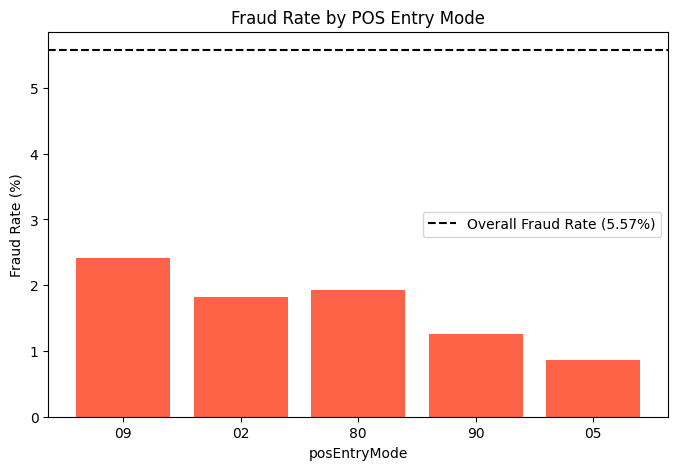

In [112]:
import matplotlib.pyplot as plt

fraud_rates = {
    "09": 0.024140,
    "02": 0.018265,
    "80": 0.019262,
    "90": 0.012587,
    "05": 0.008675
}

plt.figure(figsize=(8,5))
plt.bar(fraud_rates.keys(), [v*100 for v in fraud_rates.values()], color="tomato")
plt.axhline(5.5749, color="black", linestyle="--", label="Overall Fraud Rate (5.57%)")

plt.xlabel("posEntryMode")
plt.ylabel("Fraud Rate (%)")
plt.title("Fraud Rate by POS Entry Mode")
plt.legend()
plt.show()


## TOP MERCHANTS BY THE FRAUD RATE:

In [46]:
merchant_fraud = (
    df.groupby('merchantName')
      .agg(
          total_txns=('isFraud', 'count'),
          fraud_txns=('isFraud', 'sum'),
          fraud_rate=('isFraud', 'mean'),
          fraud_amount=('transactionAmount', lambda x: df.loc[x.index, 'isFraud'].mul(x).sum())
      )
      .reset_index()
      .sort_values(by='fraud_rate', ascending=False)
)

print(merchant_fraud.head(10))


                 merchantName  total_txns  fraud_txns  fraud_rate  \
1321         Quizno's #604182           1           1    1.000000   
610          Hardee's #398938           1           1    1.000000   
432     Dunkin' Donuts #48174           3           2    0.666667   
1485      Rodeway Inn #981618           2           1    0.500000   
35                      Aloft           2           1    0.500000   
1930        Walgreens #215972           2           1    0.500000   
2116   West End Beauty #26875          14           5    0.357143   
1771      Tim Hortons #829008           3           1    0.333333   
323    Domino's Pizza #225172           3           1    0.333333   
2110  West End Beauty #178111          15           5    0.333333   

      fraud_amount  
1321        124.78  
610         294.52  
432           0.00  
1485          0.57  
35           50.87  
1930        198.09  
2116       1091.95  
1771        190.23  
323         126.61  
2110        607.23  


West End Beauty seems to have higher transactions as fraudulent ones with with 33% of fraud rate, while other merchants like Rodeway and Dunking Donuts have no fradulent transactions.

Walgreens, Hardee, and Tim Hortons have higher fraud rate as 2 out of 3 transactions are fraud but with lower amount.

Such cases are more indicative of card testing behavior rather than large-scale financial losses.



## TOP 10 MERCHANTS BY THE FRAUD TRANSACTIONS AND FRAUD AMOUNT:

In [49]:
import pandas as pd

# Step 1: aggregate fraud & total stats per merchant
merchant_summary = (
    df.groupby('merchantName')
      .agg(
          total_txns=('isFraud','count'),
          fraud_txns=('isFraud','sum'),
          total_amount=('transactionAmount','sum'),
          fraud_amount=('transactionAmount', lambda x: df.loc[x.index, 'transactionAmount'][df.loc[x.index,'isFraud']==1].sum())
      )
      .reset_index()
)

# Step 2: Adding fraud Rate
merchant_summary['fraud_rate'] = merchant_summary['fraud_txns'] / merchant_summary['total_txns']

# Step 3: Top 10 merchants by  fraud_txns
top_merchants = (
    merchant_summary
    .sort_values(by='fraud_txns', ascending=False)
    .head(10)
)

print(top_merchants[['merchantName','fraud_rate','fraud_txns','fraud_amount']])


       merchantName  fraud_rate  fraud_txns  fraud_amount
1779           Uber    0.057018          65      10931.14
2148    walmart.com    0.066456          42       8013.98
2143    oldnavy.com    0.031297          21       3392.93
933            Lyft    0.017905          20       4758.68
2137       ebay.com    0.022472          14       2672.43
2145      sears.com    0.021739          14       2957.20
2139        gap.com    0.020927          14       3861.49
2133      apple.com    0.020376          13       2754.94
510   Fresh Flowers    0.062500          13       2825.16
2131    alibaba.com    0.019316          13       3704.45


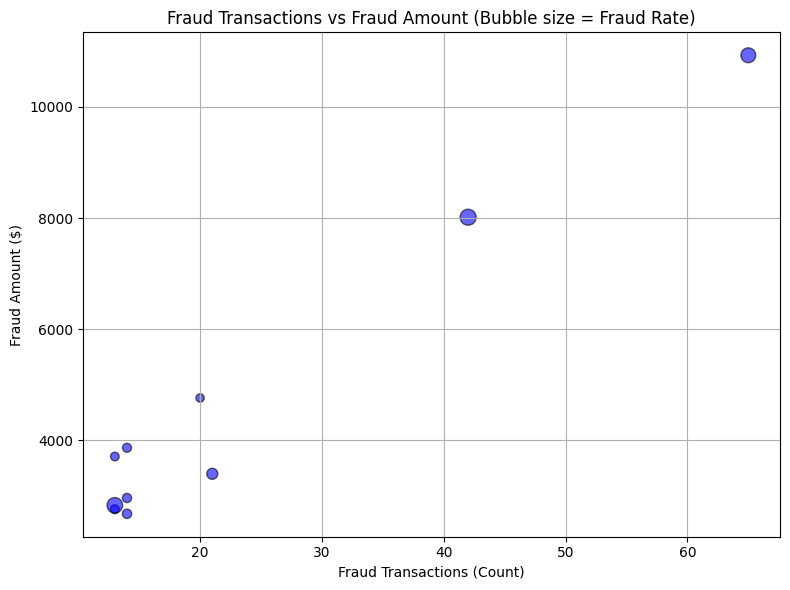

In [62]:
plt.figure(figsize=(8,6))
plt.scatter(top_merchants['fraud_txns'], top_merchants['fraud_amount'],
            s=top_merchants['fraud_rate']*2000, alpha=0.6, c='blue', edgecolors='k')

plt.xlabel("Fraud Transactions (Count)")
plt.ylabel("Fraud Amount ($)")
plt.title("Fraud Transactions vs Fraud Amount (Bubble size = Fraud Rate)")
plt.grid(True)
plt.tight_layout()
plt.show()


Uber has the highest number of fraudulent transactions (65) and the largest fraud amount (≈ $10.9K), even though its fraud rate (5.7%) is lower than some others.

walmart.com has the second-highest fraud rate (6.6%) and $8K in losses.

oldnavy.com shows a lower fraud rate (3.1%) but still notable losses ($3.4K).

Lyft has the lowest fraud rate (1.8%), but the fraud amount ($4.7K) is still high compared to some peers.




#### **Industry/merchant type differences:**

Industry/merchant type differences

Ride-sharing platforms (Uber, Lyft) both appear on the list, highlighting transportation services as a fraud-prone sector.

Retailers (Walmart, Old Navy, Gap, Sears, Apple, Alibaba) show widespread but varying levels of fraud, with large e-commerce names experiencing substantial fraud amounts.

Flowers and gifts (Fresh Flowers) face unusually high fraud relative to their size, possibly due to card-not-present transactions.

In [64]:
# Aggregate fraud & total stats per merchant and hour
hour_merchant_summary = (
    df.groupby(['Trans_Hour', 'merchantName'])
      .agg(
          total_txns=('isFraud', 'count'),
          fraud_txns=('isFraud', 'sum'),
          total_amount=('transactionAmount', 'sum'),
          fraud_amount=('transactionAmount', lambda x: df.loc[x.index, 'transactionAmount'][df.loc[x.index,'isFraud']==1].sum())
      )
      .reset_index()
)

In [70]:
top_merchants_per_hour = (
    hour_merchant_summary
    .sort_values(['Trans_Hour','fraud_amount'], ascending=[True,False])
    .groupby('Trans_Hour')
    .head(15)   # top 3 merchants per hour
)

top_merchants_per_hour.head(20)


,Trans_Hour,merchantName,total_txns,fraud_txns,total_amount,fraud_amount
465,0,target.com,28,1,3625.55,429.54
9,0,34th BBQ #192302,2,1,353.11,317.01
466,0,walmart.com,32,1,5379.35,304.59
444,0,West End Beauty #178111,3,3,218.49,218.49
100,0,Dunkin' Donuts #589280,1,1,191.13,191.13
369,0,Uber,59,2,9244.67,184.69
184,0,Krispy Kreme #369903,1,1,175.26,175.26
456,0,discount.com,22,1,3016.39,156.96
193,0,Lyft,53,1,7782.13,154.21
454,0,apple.com,23,1,3948.60,121.21


In [74]:
top_merchants_per_hour.query("Trans_Hour == 0").head(10)


,Trans_Hour,merchantName,total_txns,fraud_txns,total_amount,fraud_amount
465,0,target.com,28,1,3625.55,429.54
9,0,34th BBQ #192302,2,1,353.11,317.01
466,0,walmart.com,32,1,5379.35,304.59
444,0,West End Beauty #178111,3,3,218.49,218.49
100,0,Dunkin' Donuts #589280,1,1,191.13,191.13
369,0,Uber,59,2,9244.67,184.69
184,0,Krispy Kreme #369903,1,1,175.26,175.26
456,0,discount.com,22,1,3016.39,156.96
193,0,Lyft,53,1,7782.13,154.21
454,0,apple.com,23,1,3948.60,121.21


In [75]:
top_merchants_per_hour.query("Trans_Hour == 1").head(10)

,Trans_Hour,merchantName,total_txns,fraud_txns,total_amount,fraud_amount
651,1,Lyft,53,3,6985.97,1268.95
853,1,Uptown Diner,3,1,1437.63,626.08
921,1,walmart.com,26,3,2439.33,409.42
596,1,Fresh eCards,13,1,2582.36,373.11
918,1,sears.com,25,1,3395.56,266.09
829,1,Uber,50,2,7709.57,236.41
586,1,Franks Pub #53336,1,1,202.74,202.74
902,1,West End Beauty #240693,1,1,144.04,144.04
523,1,Boston Fries,2,1,457.88,119.90
920,1,target.com,33,1,3973.65,91.32


In [76]:
top_merchants_per_hour.query("Trans_Hour == 2").head(10)

,Trans_Hour,merchantName,total_txns,fraud_txns,total_amount,fraud_amount
1282,2,Uber,58,7,7531.43,1602.06
1370,2,walmart.com,31,3,5094.03,988.13
1356,2,alibaba.com,28,2,3888.23,797.75
1061,2,Fresh Flowers,13,3,2255.69,603.42
1154,2,Next Day eCards,8,1,1871.02,469.91
1163,2,Planet Fitness #136615,1,1,406.89,406.89
1230,2,Shell Repair,2,1,405.75,395.21
1366,2,oldnavy.com,20,1,2915.66,349.08
1358,2,apple.com,24,1,4118.95,169.84
1062,2,Fresh Online Services,10,1,1283.50,166.24


In [77]:
top_merchants_per_hour.query("Trans_Hour == 3").head(10)

,Trans_Hour,merchantName,total_txns,fraud_txns,total_amount,fraud_amount
1599,3,Mobile eCards,9,1,1442.05,589.41
1829,3,target.com,20,1,4281.72,341.94
1528,3,Hardee's #398938,1,1,294.52,294.52
1746,3,Uber,48,2,7022.53,269.11
1656,3,Ray's Fries #892291,3,1,419.43,226.30
1820,3,ebay.com,20,1,2286.46,177.88
1809,3,West End Beauty #560473,1,1,151.87,151.87
1473,3,Downtown BBQ,5,1,782.80,106.00
1511,3,Fresh eCards,9,1,948.01,90.18
1504,3,Franks Pub #87366,4,1,561.81,77.04


NameError: name 'hourly_summary' is not defined

<Figure size 800x500 with 0 Axes>

### **Top 10 Merchants with Fraud_Rate**

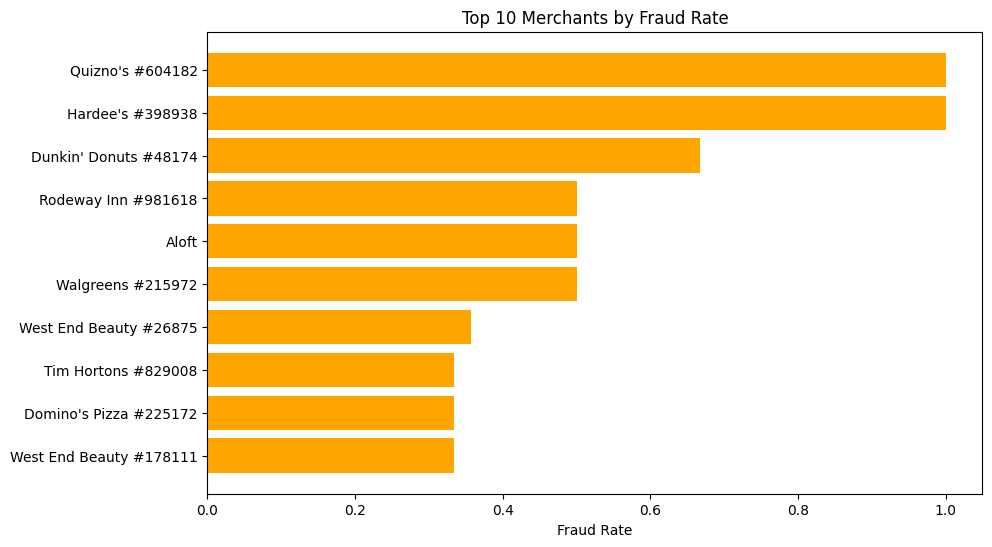

In [51]:
top10_fraud_rate = merchant_summary.sort_values(by='fraud_rate', ascending=False).head(10)

plt.figure(figsize=(10,6))
plt.barh(top10_fraud_rate['merchantName'], top10_fraud_rate['fraud_rate'], color='orange')
plt.xlabel("Fraud Rate")
plt.title("Top 10 Merchants by Fraud Rate")
plt.gca().invert_yaxis()
plt.show()


**Lets identify ranges where fraud rate increases for Creditlimit, transactionAmount and currentBalance.**

In [52]:

# Define your columns of interest
cols_to_check = ['creditLimit', 'transactionAmount', 'currentBalance']

# Set the step size for thresholds (adjust for granularity)
threshold_steps = 20  # percentiles from 10% to 90%

# Loop over each column
for col in cols_to_check:
    print(f"\n📊 Fraud Rate Analysis for: {col}")
    print("-" * 40)

    # Get min and max thresholds using percentiles
    for percentile in range(10, 100, threshold_steps):
        threshold = data[col].quantile(percentile / 100)

        fraud_rate_above = data[data[col] > threshold]['isFraud'].mean()
        fraud_rate_below = data[data[col] <= threshold]['isFraud'].mean()

        print(f"Threshold > {percentile}% ({threshold:.2f}) → Fraud Rate: {fraud_rate_above:.4f}")



📊 Fraud Rate Analysis for: creditLimit
----------------------------------------
Threshold > 10% (500.00) → Fraud Rate: 0.0167
Threshold > 30% (2500.00) → Fraud Rate: 0.0163
Threshold > 50% (5000.00) → Fraud Rate: 0.0127
Threshold > 70% (10000.00) → Fraud Rate: 0.0108
Threshold > 90% (15000.00) → Fraud Rate: 0.0116

📊 Fraud Rate Analysis for: transactionAmount
----------------------------------------
Threshold > 10% (8.31) → Fraud Rate: 0.0173
Threshold > 30% (41.29) → Fraud Rate: 0.0197
Threshold > 50% (83.99) → Fraud Rate: 0.0227
Threshold > 70% (161.64) → Fraud Rate: 0.0258
Threshold > 90% (327.52) → Fraud Rate: 0.0302

📊 Fraud Rate Analysis for: currentBalance
----------------------------------------
Threshold > 10% (34.27) → Fraud Rate: 0.0163
Threshold > 30% (370.05) → Fraud Rate: 0.0174
Threshold > 50% (1182.89) → Fraud Rate: 0.0164
Threshold > 70% (2854.06) → Fraud Rate: 0.0138
Threshold > 90% (8070.88) → Fraud Rate: 0.0109


creditLimit → Fraud rate barely changes (stays ~1.1–1.4%).
👉 Not much signal here; this feature alone may not separate fraud/non-fraud well.

transactionAmount → Fraud rate rises steadily (from 1.5% at low amounts to 2.9% at higher amounts).
👉 Clear monotonic pattern: higher transaction amounts are riskier. This looks like a useful predictor.

currentBalance → Fraud rate decreases with higher balances (from 1.4% to ~1.0%).
👉 Opposite effect: low balances might be slightly more fraud-prone.

### **Top 10 Merchants by Fraud Transactions:**

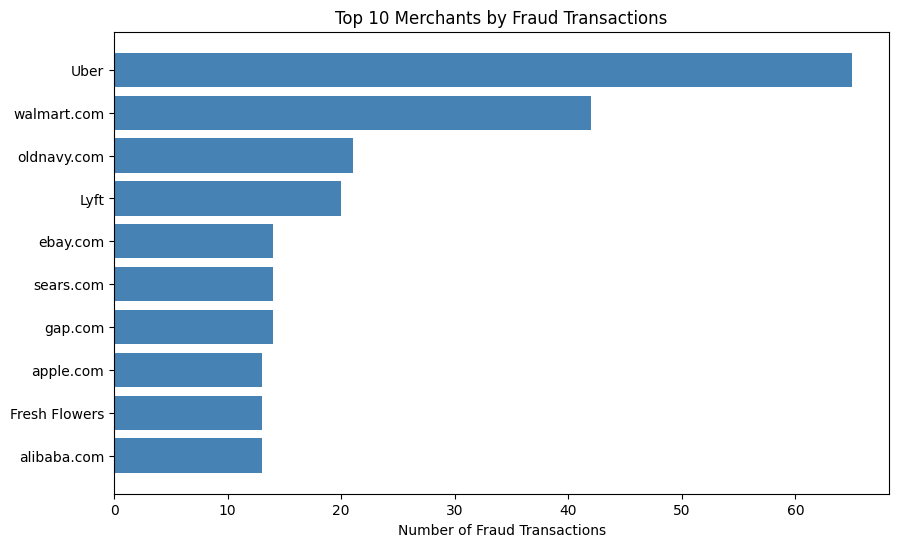

In [53]:
top10_fraud_txns = merchant_summary.sort_values(by='fraud_txns', ascending=False).head(10)

plt.figure(figsize=(10,6))
plt.barh(top10_fraud_txns['merchantName'], top10_fraud_txns['fraud_txns'], color='steelblue')
plt.xlabel("Number of Fraud Transactions")
plt.title("Top 10 Merchants by Fraud Transactions")
plt.gca().invert_yaxis()
plt.show()


### **Top 10 Merchants by Fraud Amount**:

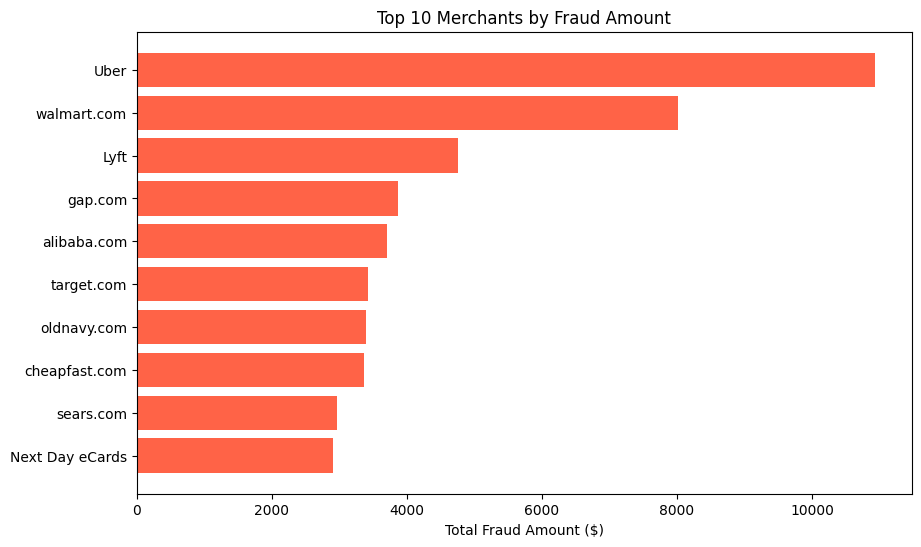

In [54]:
import matplotlib.pyplot as plt

top10_fraud_amount = merchant_summary.sort_values(by='fraud_amount', ascending=False).head(10)

plt.figure(figsize=(10,6))
plt.barh(top10_fraud_amount['merchantName'], top10_fraud_amount['fraud_amount'], color='tomato')
plt.xlabel("Total Fraud Amount ($)")
plt.title("Top 10 Merchants by Fraud Amount")
plt.gca().invert_yaxis()  # highest on top
plt.show()


### Visualization of Transaction Amounts:

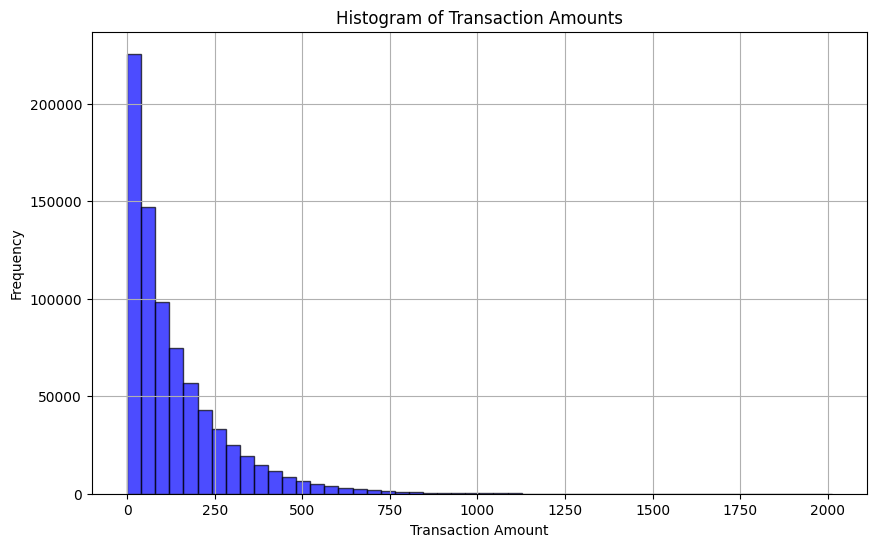

Transaction Amount Summary:
count    786363.000000
mean        136.985791
std         147.725569
min           0.000000
25%          33.650000
50%          87.900000
75%         191.480000
max        2011.540000
Name: transactionAmount, dtype: float64


In [ ]:
import matplotlib.pyplot as plt

# Plot histogram for transactionAmount
plt.figure(figsize=(10, 6))
plt.hist(df["transactionAmount"], bins=50, color='blue', edgecolor='black', alpha=0.7)
plt.title("Histogram of Transaction Amounts")
plt.xlabel("Transaction Amount")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Statistical description of transactionAmount
transaction_stats = df["transactionAmount"].describe()
print("Transaction Amount Summary:")
print(transaction_stats)

In [126]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression


X = df.drop("isFraud", axis=1)  # features
y = df["isFraud"]               # target

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42, stratify=y)

# ====================
# 2. Define Feature Groups
# ====================
numeric_features = ["creditLimit", "transactionAmount", "currentBalance",
                    "validity_years", "Trans_Hour", "Trans_year"]
log_numeric_features = ["transactionAmount"]  # optional log-transform
categorical_features = ["acqCountry", "merchantCountryCode",
                        "posEntryMode", "merchantCategoryCode",
                        "transactionType", "Trans_month_name"]
binary_features = ["cardPresent", "cvv_match", "is_night"]

# ====================
# 3. Transformers
# ====================
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

log_numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("log", FunctionTransformer(np.log1p, validate=False)),  # log(1+x)
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

binary_transformer = "passthrough"  # already 0/1

# ====================
# 4. ColumnTransformer
# ====================
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("log_num", log_numeric_transformer, log_numeric_features),
        ("cat", categorical_transformer, categorical_features),
        ("bin", binary_transformer, binary_features),
    ]
)

# ====================
# 5. Final Pipeline
# ====================
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", LogisticRegression(max_iter=1000, class_weight= "balanced"))
])

# ====================
# 6. Fit on Train, Predict on Test
# ====================
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)



In [127]:
y_pred

array([False,  True, False, ..., False, False, False])

In [128]:
from sklearn.metrics import accuracy_score, confusion_matrix
accuracy_score(y_test,y_pred)
confusion_matrix(y_test,y_pred)

array([[3875, 1718],
       [  28,   64]])

In [130]:
accuracy_score(y_test,y_pred)

0.6928759894459103

In [ ]:
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", RandomForest(max_iter=1000, class_weight= "balanced"))
])

In [129]:
y_test

,isFraud
7171,False
26833,True
14257,False
11863,False
18338,False
...,...
858,False
5137,False
25719,False
16885,False


The histogram above illustrates the distribution of transaction amounts and their frequency. The data shows that transaction peaks occur predominantly for amounts less than **250,** with a mean transaction value of **136.** Additionally, **75%** of users spend **191** or less on their transactions, indicating that the majority of users make transactions below **200**.

In [ ]:
import pandas as pd
from scipy.stats import chi2_contingency

categorical_cols = ['merchantName', 'merchantCountryCode', 'acqCountry',
                    'posEntryMode', 'merchantCategoryCode', 'transactionType']

# Step 1: Fill NA if any
data_chiSquare[categorical_cols] = data_chiSquare[categorical_cols].fillna('Unknown')

results = []
for col in categorical_cols:
    ct = pd.crosstab(data_chiSquare[col], data_chiSquare['isFraud'])
    chi2_stat, p, dof, expected = chi2_contingency(ct, correction=False)
    results.append((col, chi2_stat, p, dof))

chi2_results = (pd.DataFrame(results, columns=['Feature', 'Chi2_Score', 'P_Value', 'DOF'])
                .sort_values('P_Value')
                .reset_index(drop=True))

print("📊 Chi-Square per feature (contingency table):")
print(chi2_results)

📊 Chi-Square per feature (contingency table):
                Feature   Chi2_Score       P_Value   DOF
0          merchantName  8475.522570  0.000000e+00  2489
1          posEntryMode  3018.782019  0.000000e+00     5
2  merchantCategoryCode  3772.066364  0.000000e+00    18
3   merchantCountryCode   456.257030  1.928075e-97     4
4       transactionType   135.358748  3.785107e-29     3
5            acqCountry    96.672167  5.024240e-20     4


In [ ]:
import pandas as pd
from scipy.stats import ttest_ind

# Select only numeric columns (int, float)
numeric_cols = data.select_dtypes(include=['number']).columns.tolist()

results = []

for col in numeric_cols:
    group1 = data[data['isFraud'] == 1][col].dropna()
    group0 = data[data['isFraud'] == 0][col].dropna()

    # Skip if one group is empty
    if group1.empty or group0.empty:
        continue

    stat, p = ttest_ind(group1, group0, equal_var=False)  # Welch’s t-test

    results.append({
        "Feature": col,
        "T_Statistic": stat,
        "P_Value": p
    })

# Convert to DataFrame
ttest_results = pd.DataFrame(results)

# Sort by P_Value (lowest = most significant)
ttest_results = ttest_results.sort_values(by="P_Value").reset_index(drop=True)

print(ttest_results)


             Feature  T_Statistic       P_Value
0  transactionAmount    52.449187  0.000000e+00
1     currentBalance     6.253031  4.154165e-10
2        creditLimit     2.686116  7.238134e-03
3     availableMoney    -1.391201  1.641887e-01


### 3.Model Developement and Evaluation Phase:

### Implementing Logistic Regression Model

### **Implementing Random Forest Model**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

X = Cleaned_df.drop(columns=['isFraud'])
y = Cleaned_df['isFraud']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Initialize the Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10, class_weight='balanced')

# Train the model
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_model.predict(X_test)
y_proba = rf_model.predict_proba(X_test)[:, 1]  # Probabilities for ROC-AUC

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nROC-AUC Score:")
roc_auc = roc_auc_score(y_test, y_proba)
print(roc_auc)


Confusion Matrix:
[[14865   738]
 [  141    87]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97     15603
           1       0.11      0.38      0.17       228

    accuracy                           0.94     15831
   macro avg       0.55      0.67      0.57     15831
weighted avg       0.98      0.94      0.96     15831


ROC-AUC Score:
0.8213535183854657


Overall accuracy is high (94%), but it’s misleading because of severe class imbalance.

The model performs very well for legit transactions, but poorly for fraud detection (precision 0.11, recall 0.38).

ROC-AUC is more reliable than accuracy here:

If it’s low (<0.6) → model is weak at separating fraud from legit.

If it’s decent (>0.7) → model has potential, but you need to adjust threshold or resampling techniques.

The main issue: too many frauds missed (141) and too many false alarms (738) → not practical for a bank/fraud system.

If ROC-AUC is >0.8, it means your model can discriminate, but the chosen threshold is too high.

You may improve recall (catch more fraud) by lowering the decision threshold.

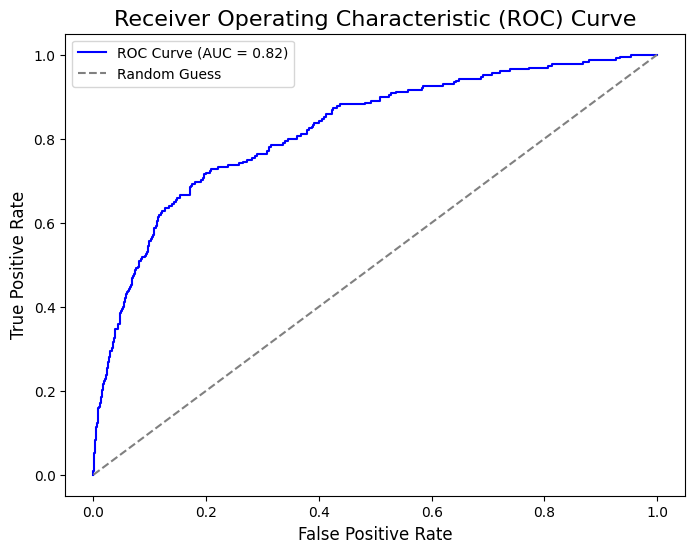

Best Threshold: 0.2858381823493353


In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Guess')
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.legend()
plt.show()


# Get FPR, TPR, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# Calculate Youden's J statistic
youden_j = tpr - fpr

# Find the index of the best threshold
best_threshold_index = youden_j.argmax()
best_threshold = thresholds[best_threshold_index]

print("Best Threshold:", best_threshold)


In [ ]:

X = Cleaned_df.drop(columns=['isFraud'])
y = Cleaned_df['isFraud']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Initialize the Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10, class_weight='balanced')

# Train the model
rf_model.fit(X_train, y_train)

# Predict probabilities
y_probs = rf_model.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class

# Adjust threshold
threshold = 0.30  # Set a new threshold
y_pred_adjusted = (y_probs >= threshold).astype(int)

# Evaluate metrics
print("Confusion Matrix with Adjusted Threshold:")
print(confusion_matrix(y_test, y_pred_adjusted))

print("\nClassification Report with Adjusted Threshold:")
print(classification_report(y_test, y_pred_adjusted))

Confusion Matrix with Adjusted Threshold:
[[12753  2850]
 [   69   159]]

Classification Report with Adjusted Threshold:
              precision    recall  f1-score   support

           0       0.99      0.82      0.90     15603
           1       0.05      0.70      0.10       228

    accuracy                           0.82     15831
   macro avg       0.52      0.76      0.50     15831
weighted avg       0.98      0.82      0.89     15831



The confusion matrix and classification report reveal several key insights into our **baseline logistic regression model** for fraud detection.


In fraud detection, missing a fraudulent transaction (False Negative) is far more dangerous than flagging a legitimate one (False Positive).

Our primary goal is to minimize false negatives (FN).

True Negatives (TN) = 6794
→ These are legitimate transactions correctly identified as not fraud.

False Positives (FP) = 3616
→ These are legitimate transactions incorrectly flagged as fraud (false alarms).

False Negatives (FN) = 54
→ These are fraudulent transactions that the model missed (classified as not fraud).

True Positives (TP) = 90
→ These are fraudulent transactions correctly detected.

The model is catching 90 fraud cases, but it’s missing 54 fraud cases → recall is decent but not perfect.

The Model is incorrectly predicting legitimate transactions as fraudulent and also missing some fraud transactions, classifying it as non fraudulent.

The model is very imbalanced toward flagging too many transactions as fraud (lots of false positives).


Trade-off observed: Accuracy dropped, but recall for fraud improved significantly (38% - 70%). Good for fraud detection if the main business goal is to catch as many frauds as possible, even at the cost of false alarms.

This shows threshold tuning works (0.30 adjusted value), but now we need to balance precision vs recall more carefully.

Overall accuracy looks high at 94% initially, but that’s misleading because the dataset is highly imbalanced (fraud cases are rare).

After threshold adjustment, accuracy fell to 82%, but this actually represents a better trade-off because fraud detection improved.   

### **Which models works better?**

**Recommended Model: Adjusted Threshold Model with 0.30 (Model 3)**

**Why Choose This Model?**

Initial model: High accuracy but poor fraud detection → not reliable.

Fraud detection improved (recall ↑ from 38% → 70%). At the cost of more false alarms (precision ↓ from 11% → 5%). Overall, the model is now more sensitive to fraud but less precise.

This shows the precision–recall trade-off clearly.

## lets see which features are contributing most towards fraudulent activities

In [ ]:
# Feature Importance (optional)
feature_importance = rf_model.feature_importances_
for name, importance in zip(X.columns, feature_importance):
    print(f"{name}: {importance:.4f}")

accountNumber: 0.0682
creditLimit: 0.0326
availableMoney: 0.0659
transactionAmount: 0.1596
enteredCVV: 0.0674
cardLast4Digits: 0.0632
currentBalance: 0.0681
cardPresent: 0.0149
trans_hour: 0.0462
trans_weekday: 0.0248
trans_month: 0.0405
daily_txn_count: 0.0547
validity_days: 0.0606
merchantName_FE: 0.0971
merchantCountryCode_LE: 0.0043
posEntryMode_LE: 0.0600
merchantCategoryCode_LE: 0.0691
transactionType_LE: 0.0029


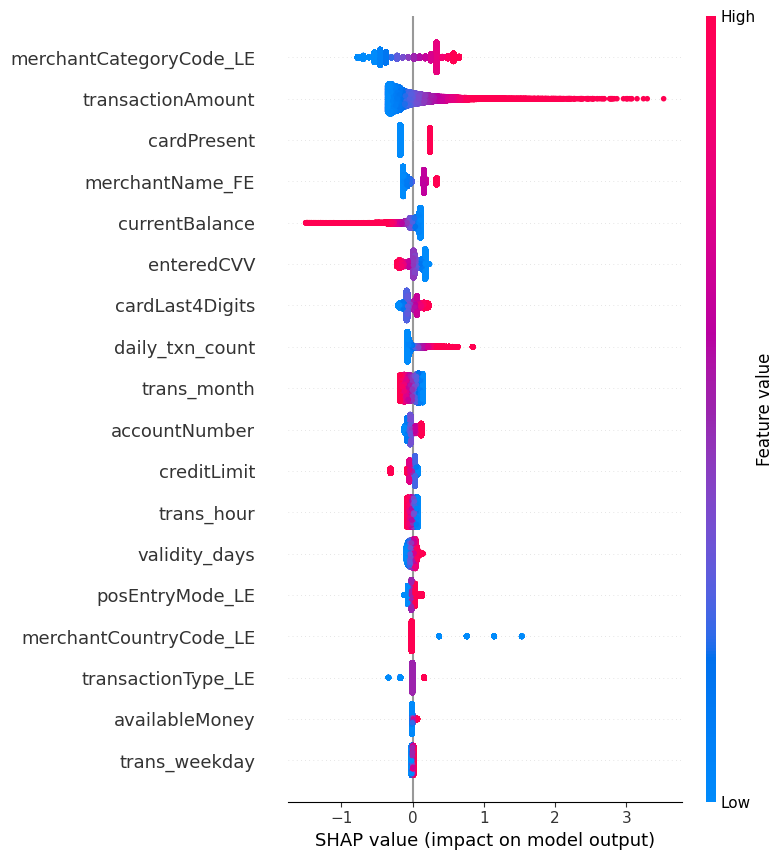

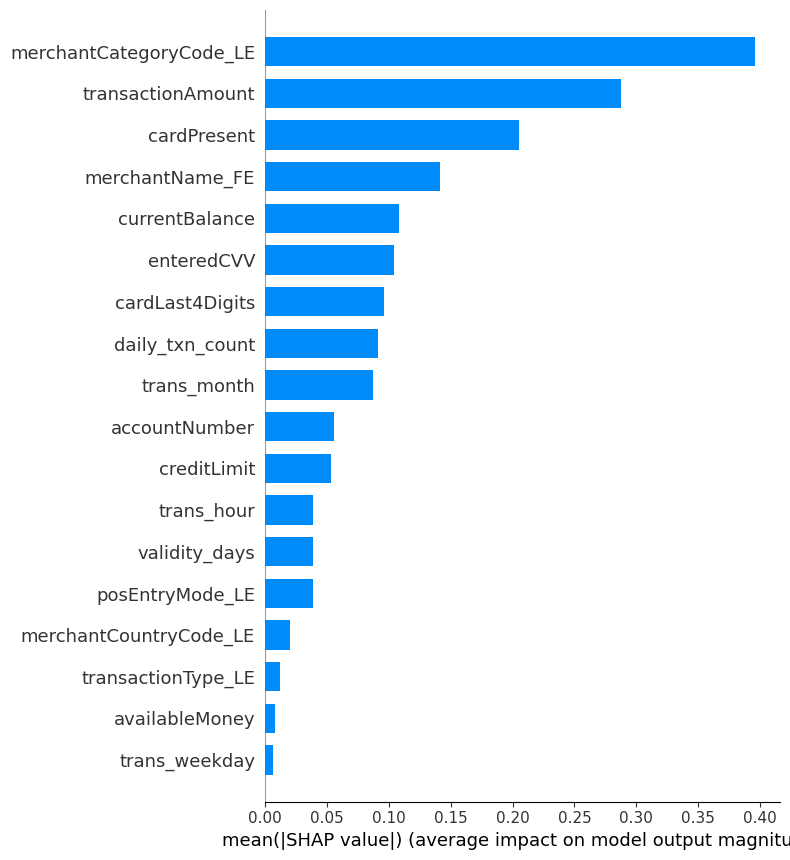

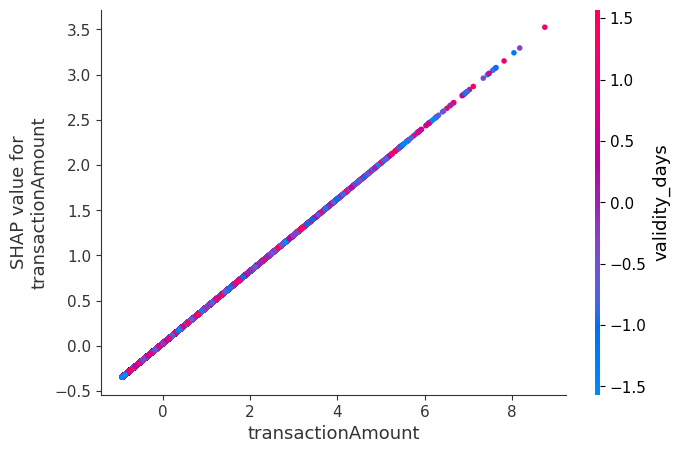

In [ ]:
import shap
import matplotlib.pyplot as plt


# Scale the entire X dataset using the previously fitted scaler
X_scaled = scaler.transform(X)

# Create explainer using the scaled data
explainer = shap.LinearExplainer(model, X_scaled)   # for linear models
shap_values = explainer.shap_values(X_scaled)

# 1. Summary plot (global feature importance)
shap.summary_plot(shap_values, X_scaled, feature_names=X.columns)

# 2. Bar plot (average absolute SHAP values)
shap.summary_plot(shap_values, X_scaled, plot_type="bar", feature_names=X.columns)

# 3. Force plot for a single prediction
# Pick one fraud transaction, e.g., index 100
shap.force_plot(explainer.expected_value, shap_values[100,:], X_scaled[100,:], feature_names=X.columns)

# 4. Dependence plot (interaction between feature and fraud prediction)
shap.dependence_plot("transactionAmount", shap_values, X_scaled, feature_names=X.columns)

**Top predictors of fraud:**

**transactionAmount (0.1596)** is the strongest feature → fraud is often associated with unusual transaction amounts.

**merchantName_FE (0.0971)** is also highly important → some merchants or merchant groups may be associated with more fraud attempts.

Other strong signals: **merchantCategoryCode_LE (0.0691),** **accountNumber (0.0682),** **currentBalance (0.0681),** **enteredCVV (0.0674).**

**Moderate predictors:**

Features like validity_days, posEntryMode_LE, availableMoney, and daily_txn_count contribute meaningfully but less than the top ones.

### **Conclusion:**

From our Exploratory Data Analysis, Model Performance and Feature Importance we have below insights and Recommendations for Business.

-  Account number, Transaction Amount, Merchant Category and MerchantName are them most crucial features which are prone towards fraudelent transactions.



-  If we dig deeper from our earlier visualisation we can see that Account number 380680241 have had  907 reverse transactions and (#882815134) had 384 reverse trasactions. These two accounts needs further investigation in terms of Transaction Amount an  frequency of reversal within days or hours.

-  Also, the merchants like Lyft with  692, Uber with 689, alibaba.com with 499 and ebay.com with 491 are topmost merchant which usually are Ecommerce platform. Ridesharing services and Online trading platform have most of transaction reversal, which requires further investigation and monitoring.



## **THANKYOU**